In [2]:
import signal

class TimeOut:
    """force timing out for things that get stuck"""
    def __init__(self, seconds=1, error_message='Timeout'):
        self.seconds = seconds
        self.error_message = error_message

    def handle_timeout(self, signum, frame):
        """handle timeout"""
        raise TimeoutError(self.error_message)

    def __enter__(self):
        signal.signal(signal.SIGALRM, self.handle_timeout)
        signal.alarm(self.seconds)

    def __exit__(self, type, value, traceback):
        signal.alarm(0)

# Extract pole-like street furniture

In this notebook we demonstrate how we can extract pole-like objects form labeled point clouds.

In this code we assume the point clouds have been labelled following the process in our [Urban PointCloud Processing](https://github.com/Amsterdam-AI-Team/Urban_PointCloud_Processing/tree/main/datasets) project. For more information on the specifics of the datasets used, see [the description there](https://github.com/Amsterdam-AI-Team/Urban_PointCloud_Processing/blob/main/datasets/README.md).

In [3]:
# Add project src to path.
import set_path

import numpy as np
import pandas as pd
import os
import pathlib
import laspy
from tqdm import tqdm

#from upcp.labels import Labels 
from labels import Labels
from upcp.utils import las_utils
from upcp.utils import ahn_utils
import upcp.utils.bgt_utils as bgt_utils
from upc_analysis import PoleExtractor 
from upc_analysis import visualization 

In [5]:
base_folder = '../../../code/blobfuse/ovl'

# We provide some example data for demonstration purposes.
dataset_folder = f'{base_folder}/pointcloud/' # folder with point clouds
pred_folder = f'{base_folder}/preds/' # folder with predictions as npz files
prefix = 'filtered_'
prefix_pred = 'pred_'
files = list(pathlib.Path(dataset_folder).glob(f'{prefix}*.laz'))

# Only predictions were made for files bigger than 10kb
files = [f for f in files if os.path.getsize(f) > 10000] 

# Define the class we are interested in
target_label = 60  

# Labels used for ground points ('Road' and 'Other ground')
ground_labels = [1, 9]

# AHN data reader for elevation data. This is optional: the data is only used when
# the ground elevation cannot be determined from the labeled point cloud itself.
ahn_data_folder = f'{base_folder}/ahn/'
ahn_reader = ahn_utils.NPZReader(ahn_data_folder, caching=False)

# BGT data reader for building shapes. This is optional: the data is used to check
# whether an extracted object is located within a building footprint. This might
# indicate a false positive.
# If an appropriate dataset is available, uncomment these lines to use it:
if os.path.exists(f'{base_folder}/bgt/bgt_buildings_oost.csv'):
    bgt_building_file = f'{base_folder}/bgt/bgt_buildings_oost.csv'
    bld_reader = bgt_utils.BGTPolyReader(bgt_building_file)
else:
    bld_reader = None

# Define and create out folder for images of found clusters
img_out_folder = f'{base_folder}/images/'
if not os.path.isdir(img_out_folder):
    os.makedirs(img_out_folder + 'object_all_axes/')
    os.makedirs(img_out_folder + 'object_per_axis/x/')
    os.makedirs(img_out_folder + 'object_per_axis/y/')

In [6]:
# Settings for noise filtering
EPS_N = 0.4
MIN_SAMPLES_N = 10

# Settings for clustering
EPS = 1
MIN_SAMPLES = 200

In [7]:
import time
timestr = time.strftime("%Y%m%d-%H%M%S")

my_settings = str(MIN_SAMPLES_N) + '_' + str(int(EPS_N*10)) + '_' + str(MIN_SAMPLES) + '_' + str(int(EPS*10))
output_file = f'{base_folder}/{timestr}_poles_extracted_' + my_settings + '.csv'

---
## Extracting pole-like objects

This method works by clustering points of a given target class, and then using statistics and PCA analysis on each cluster to determine the exact pole.

The result is a dataset with the following features for each extracted object:
```txt
rd_x, rd_y, z = X, Y, Z coordinates of the base of the pole
tx, ty, tz    = X, Y, Z coordinates of the top of the pole
height        = the height of the pole, in m
angle         = the angle of the pole, in degrees w.r.t. vertical
prob          = the average probability of the classification, if this data is available in the point cloud
n_points      = the number of points of the object
in_bld        = flag that indicates whether the object is located inside a building footprint
debug         = debug code, see below
tilecode      = tilecode in which the object was found
```
The debug code `A_B` indicates potential issues with either the ground elevation (A) or the pole extraction (B). A can be either 0 (no problems), 1 (no ground elevation found in the point cloud), or 2 (no ground elevation found in AHN). B can be either 0 (no problems), 3 (not enough data to determine the angle), or 4 (not enough data to determine the exact location).

In [8]:
# Create PoleExtractor object
pole_extractor = PoleExtractor(target_label, ground_labels,
                               ahn_reader=ahn_reader, building_reader=bld_reader,
                               eps_noise=EPS_N, min_samples_noise=MIN_SAMPLES_N,
                               eps=EPS, min_samples=MIN_SAMPLES)   

In [9]:
# Loop over point cloud files and extract objects
locations = []
for file in tqdm(files):
    try:
        with TimeOut(240):
            tilecode = las_utils.get_tilecode_from_filename(file.as_posix())
            pc = laspy.read(file)
            npz_file = np.load(pred_folder + prefix_pred + tilecode + '.npz')
            labels = npz_file['label']
            if 'probability' in pc.point_format.extra_dimension_names:
                probabilities = pc.probability
            else:
                probabilities = np.zeros_like(labels)
            print(np.count_nonzero(labels == target_label))
            if np.count_nonzero(labels == target_label) > 0:
                points = np.vstack((pc.x, pc.y, pc.z)).T
                colors = np.vstack((pc.green, pc.red, pc.blue)).T
                tile_locations = pole_extractor.get_pole_locations(points, colors, labels, probabilities, tilecode)
                locations.extend([(*x, tilecode) for x in tile_locations])
    except:
        continue

HEADERS = ['rd_x', 'rd_y', 'z', 'tx', 'ty', 'tz', 'height', 'angle', 'm_r', 'm_g', 'm_b', 'radius','prob', 'n_points', 'in_bld', 'debug', 'tilecode']
poles_df = pd.DataFrame(locations, columns=HEADERS)

100%|██████████| 6/6 [00:54<00:00,  9.15s/it]


0
0
0
18669
../../../code/blobfuse/ovl/pointcloud/filtered_2444_9713.laz
[(122232.59, 485682.32, 0.61, 122232.06, 485681.83, 8.88, 8.3, 4.96, 15483.47, 15836.8, 16175.31, 3.462, 0.0, 726, 0, '0_0'), (122231.4, 485667.57, 1.84, 122230.43, 485670.17, 1.92, 2.78, 88.47, 10916.57, 11042.24, 11558.23, 5.588, 0.0, 385, 0, '0_0'), (122225.34, 485690.02, 0.35, 122225.3, 485689.93, 3.7, 3.34, 1.66, 16252.02, 15928.55, 15912.67, 0.12, 0.0, 313, 0, '0_0'), (122238.58, 485659.3, 0.59, 122238.21, 485659.13, 4.65, 4.08, 5.75, 15001.01, 16159.64, 15587.46, 0.272, 0.0, 354, 0, '1_0'), (122248.38, 485677.27, 0.42, 122248.43, 485677.42, 3.31, 2.9, 3.18, 17881.84, 17873.58, 19227.9, 0.232, 0.0, 578, 0, '0_0')]
10132
../../../code/blobfuse/ovl/pointcloud/filtered_2444_9714.laz
[(122227.08, 485703.46, 0.63, 122226.83, 485703.49, 4.76, 4.14, 3.58, 12431.29, 13863.34, 13472.36, 0.289, 0.0, 499, 0, '0_0'), (122228.96, 485700.71, 0.65, 122228.91, 485700.73, 7.78, 7.14, 0.43, 13245.25, 13603.37, 14028.64, 1.235

In [10]:
poles_df.head(2)

,rd_x,rd_y,z,tx,ty,tz,height,angle,m_r,m_g,m_b,radius,prob,n_points,in_bld,debug,tilecode
0,122232.59,485682.32,0.61,122232.06,485681.83,8.88,8.30,4.96,15483.47,15836.80,16175.31,3.462,0.0,726,0,0_0,2444_9713
1,122231.40,485667.57,1.84,122230.43,485670.17,1.92,2.78,88.47,10916.57,11042.24,11558.23,5.588,0.0,385,0,0_0,2444_9713


In [11]:
# Save the data in CSV format.
poles_df.to_csv(output_file, index=False)

---
## Visualize extracted poles

In order to verify the results and spot potential issues, we can visualize individual objects. The visualization renders the object from two directions (X and Y axis), along with a 3D projection.

In [12]:
# Optional: load data from CSV.
poles_df = pd.read_csv(output_file)

In [13]:
len(poles_df)

15

#### Loop over all poles

In [14]:
%matplotlib inline

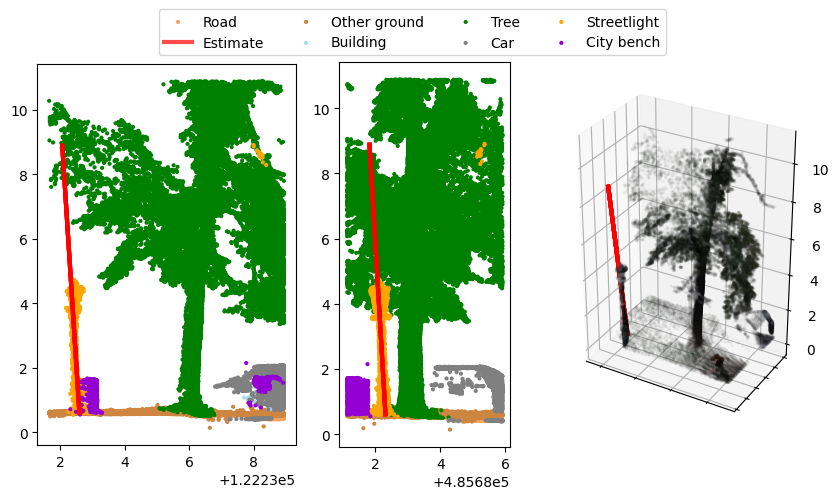

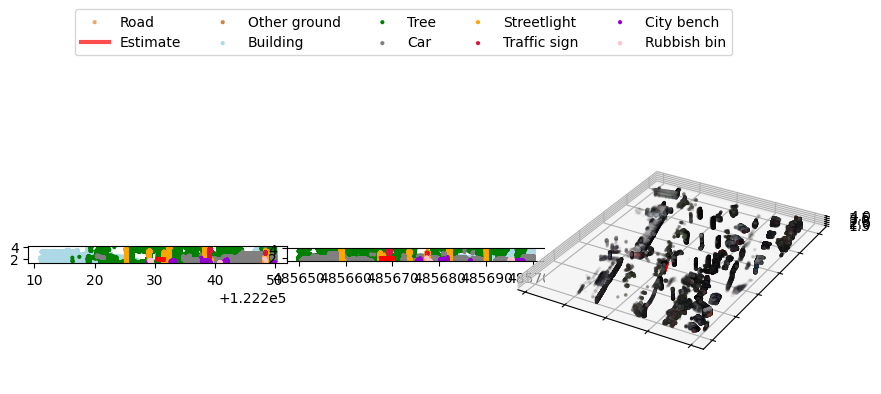

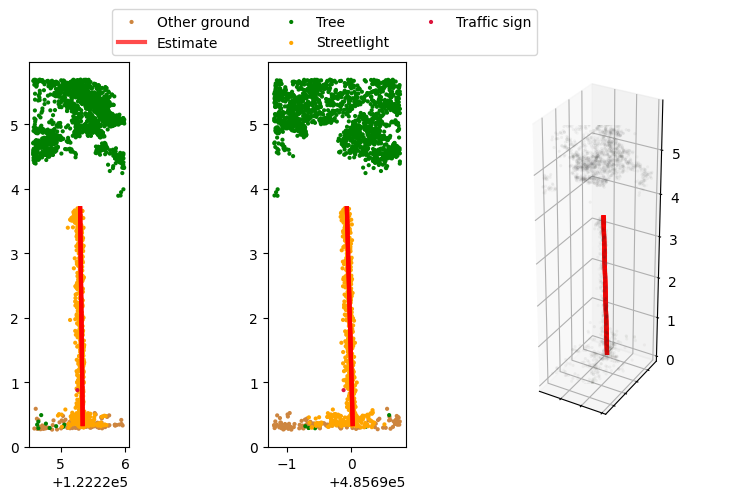

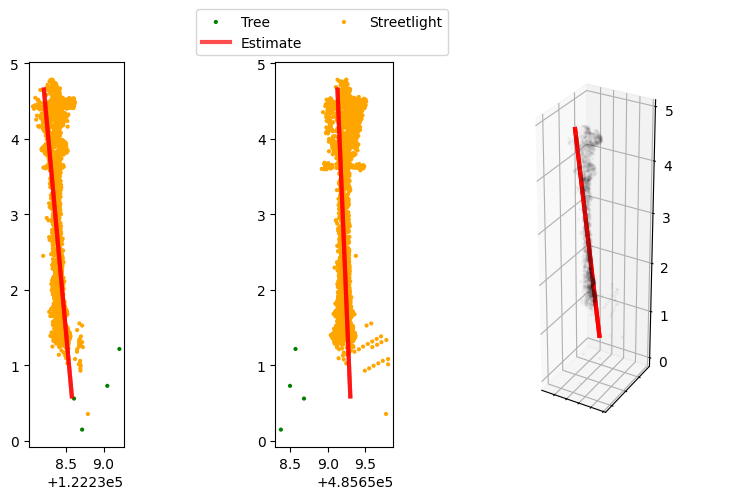

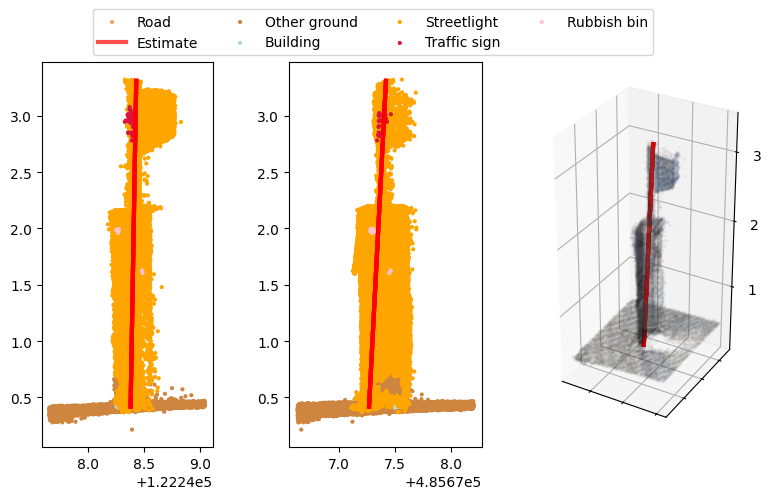

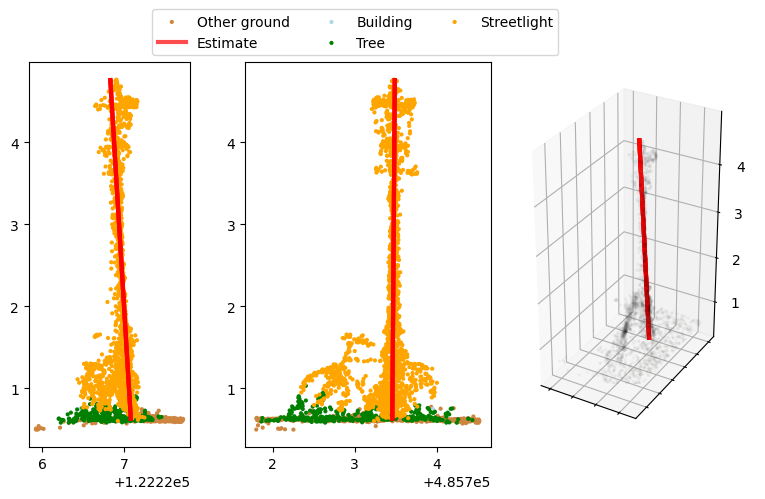

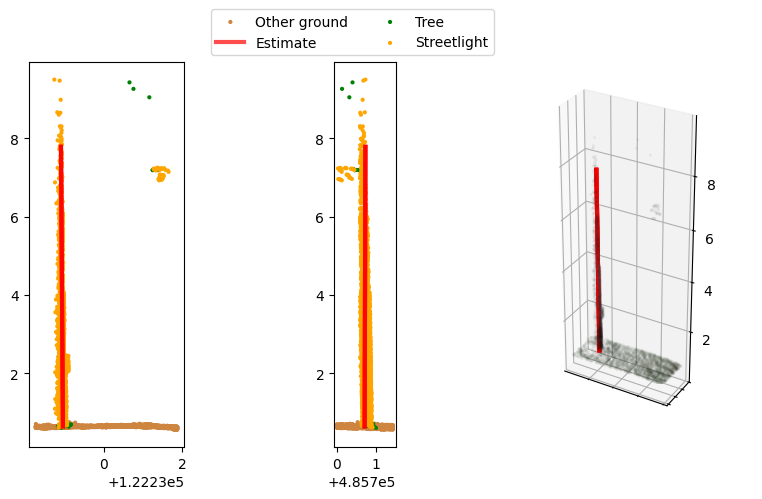

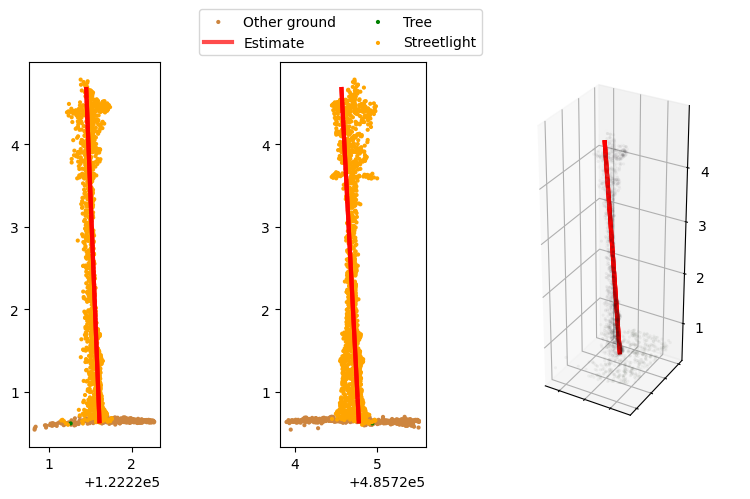

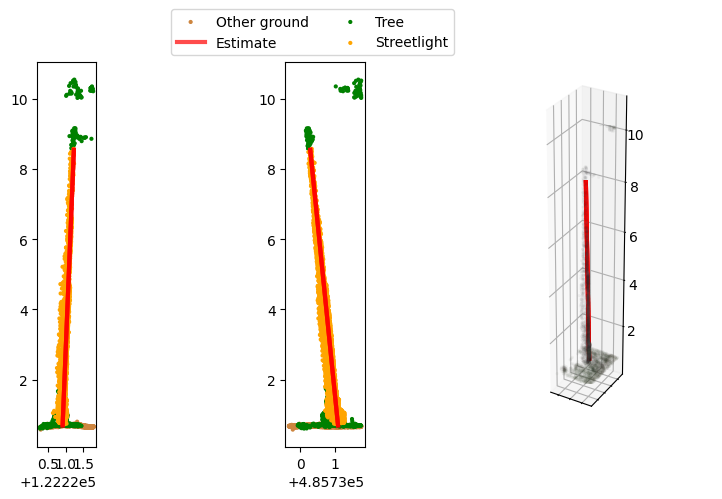

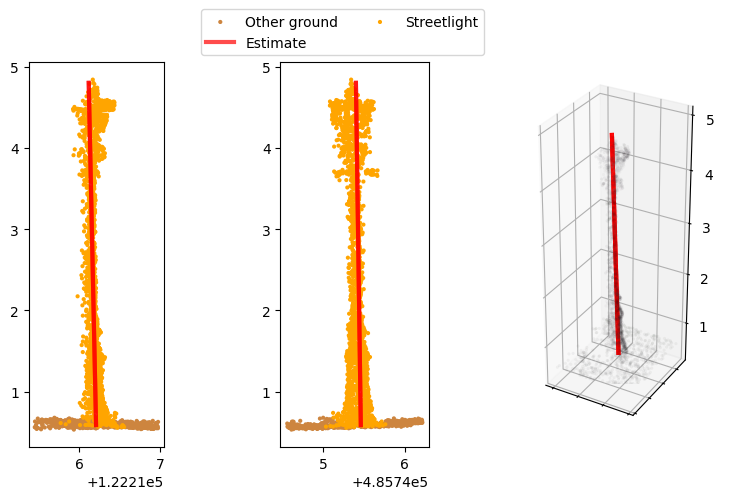

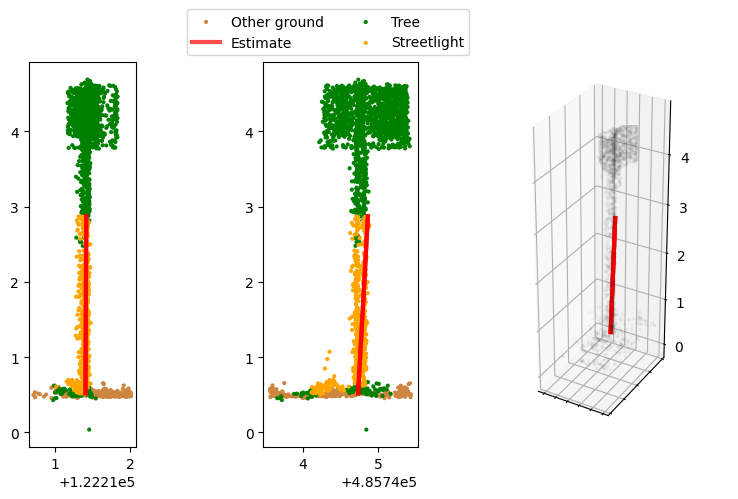

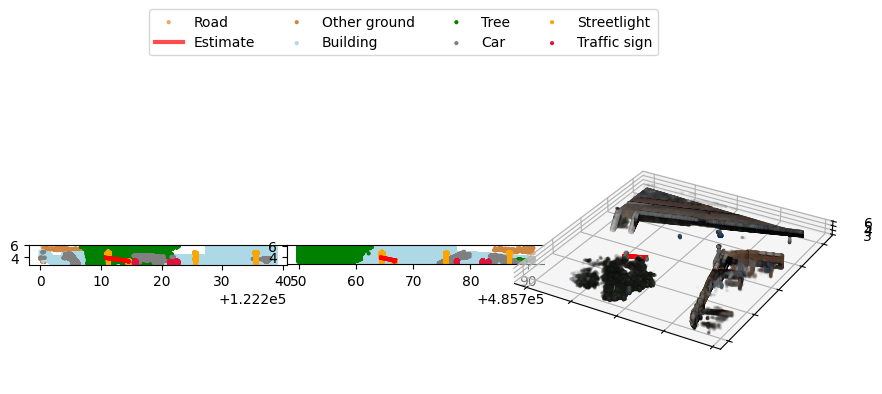

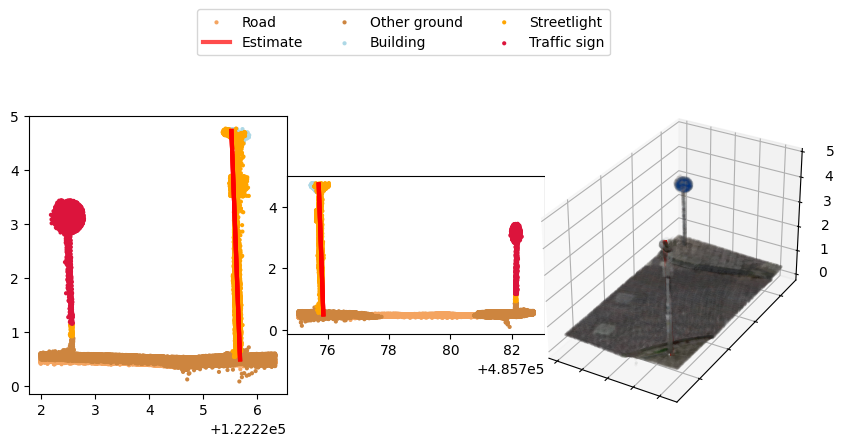

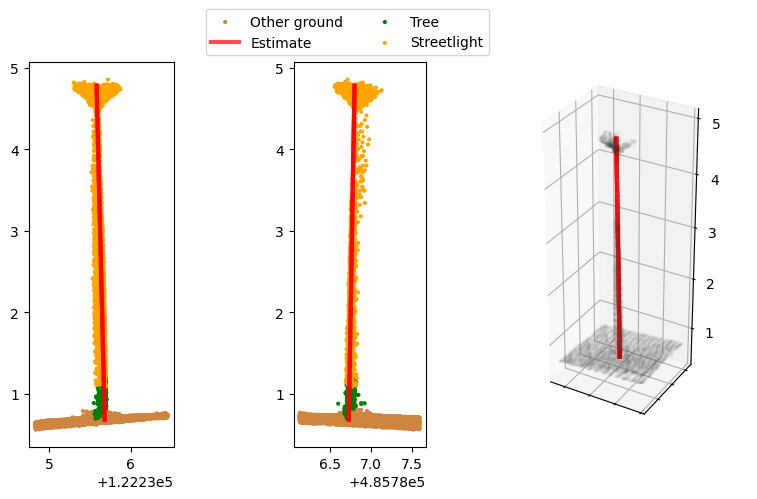

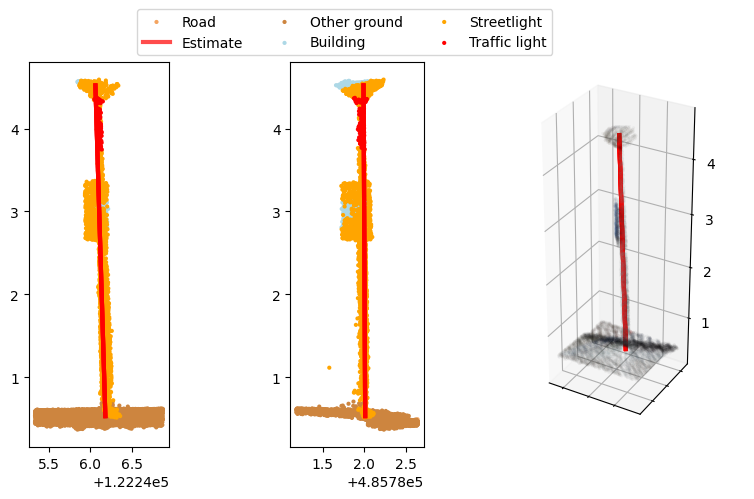

In [15]:
for row_id in range(0, len(poles_df)): 
    # Get the object features
    obj = poles_df.loc[row_id]
    obj_location = (obj.rd_x, obj.rd_y, obj.z)
    obj_top = (obj.tx, obj.ty, obj.tz)

    # Load the point cloud data for the tile containing this object
    cloud = laspy.read(f'{dataset_folder}{prefix}{obj.tilecode}.laz')
    points = np.vstack((cloud.x, cloud.y, cloud.z)).T
    npz_file = np.load(pred_folder + prefix_pred + obj.tilecode + '.npz')
    labels = npz_file['label']
    colors = np.vstack((cloud.red, cloud.green, cloud.blue)).T / (2**16 - 1)

    # Get a mask for the point cloud around the object's location
    obj_mask = visualization.get_mask_for_obj(points, labels, target_label, obj_location, obj_top[2],
                                              obj_angle=obj.angle, noise_filter=True,
                                              eps_noise=EPS_N, min_samples_noise=MIN_SAMPLES_N,
                                              eps=EPS, min_samples=MIN_SAMPLES)
    
    # Create path to store output image
    output_path = f'{base_folder}/images/{timestr}_output_image_' + my_settings + '_' + str(row_id) + '.png'

    # Show the object and store
    visualization.plot_object(points[obj_mask], labels[obj_mask], colors=colors[obj_mask],
                              estimate=np.vstack((obj_location, obj_top)), output_path=output_path)

#### Look at one pole

In [16]:
# Either choose a row number of sample one randomly
row_id = 0
# idx = np.random.randint(0, len(poles_df))
# row_id = poles_df.index[idx]

# Get the object features
obj = poles_df.loc[row_id]
obj_location = (obj.rd_x, obj.rd_y, obj.z)
obj_top = (obj.tx, obj.ty, obj.tz)

# Let's see the object in question
poles_df.loc[[row_id]]

,rd_x,rd_y,z,tx,ty,tz,height,angle,m_r,m_g,m_b,radius,prob,n_points,in_bld,debug,tilecode
0,122232.59,485682.32,0.61,122232.06,485681.83,8.88,8.3,4.96,15483.47,15836.8,16175.31,3.462,0.0,726,0,0_0,2444_9713


In [17]:
# Load the point cloud data for the tile containing this object
cloud = laspy.read(f'{dataset_folder}{prefix}{obj.tilecode}.laz')
points = np.vstack((cloud.x, cloud.y, cloud.z)).T
npz_file = np.load(pred_folder + prefix_pred + obj.tilecode + '.npz')
labels = npz_file['label']
colors = np.vstack((cloud.red, cloud.green, cloud.blue)).T / (2**16 - 1)

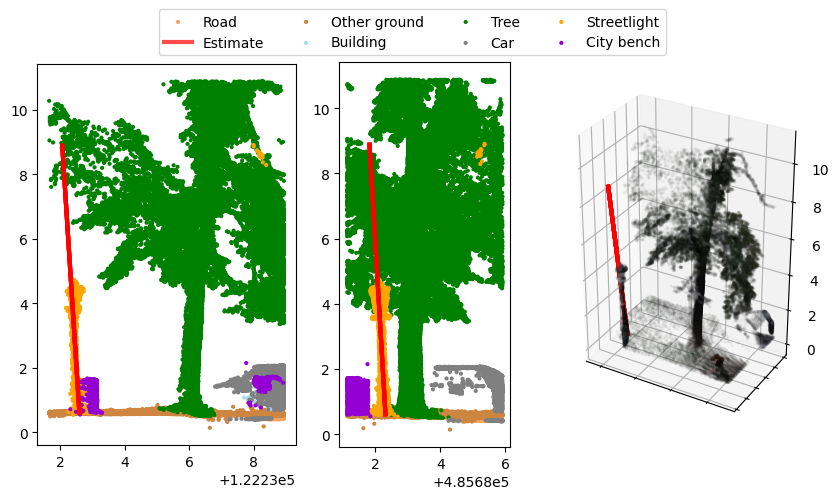

In [18]:
# Get a mask for the point cloud around the object's location
obj_mask = visualization.get_mask_for_obj(points, labels, target_label, obj_location, obj_top[2],
                                          obj_angle=obj.angle, noise_filter=True,
                                          eps_noise=EPS_N, min_samples_noise=MIN_SAMPLES_N,
                                          eps=EPS, min_samples=MIN_SAMPLES)

# Create path to store output image
output_path = f'{base_folder}/images/{timestr}_output_image_' + my_settings + '_' + str(row_id) + '.png'

# Show the object and store
visualization.plot_object(points[obj_mask], labels[obj_mask], colors=colors[obj_mask],
                          estimate=np.vstack((obj_location, obj_top)), output_path=output_path)

In [19]:
# Print location (to be pasted in Google Maps)
import geopandas as gpd
import shapely.geometry as sg
my_lon = float(poles_df.loc[[row_id]]['rd_x'])
my_lat = float(poles_df.loc[[row_id]]['rd_y'])
df_loc = gpd.GeoDataFrame({'geometry': [sg.Point(my_lon, my_lat)]}, crs='epsg:28992').to_crs("epsg:4326") 
print(float(df_loc['geometry'].y), float(df_loc['geometry'].x))

52.35805872257545 4.906197082236531
